In [1]:
!pip install -q transformers # sets up a time series transformer model with specific configurations, considering aspects such as prediction length, context length, lag sequences, time and categorical features, and transformer architecture parameters. The created model is then ready for training and making predictions on time series data.

!pip install -q datasets # to load input data

!pip install -q evaluate # to use error metric

!pip install -q accelerate # to imporove the performance

!pip install -q gluonts ujson # toolkit for building time series forecasting models using deep learning.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 7.3 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

dataset = load_dataset("monash_tsf", "tourism_monthly")
dataset

Generating train split:   0%|          | 0/366 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/366 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/366 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
})

In [3]:
train_example = dataset['train'][0] # [0]...[1]... represents the product index wise. Since it has 366 prouducts each with train + test = prediction count
# train_example

In [4]:
validation_example = dataset['validation'][0]
validation_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [5]:
freq = "1M"
prediction_length = 24

assert len(train_example["target"]) + prediction_length == len(validation_example["target"])

In [6]:
len(train_example["target"])

139

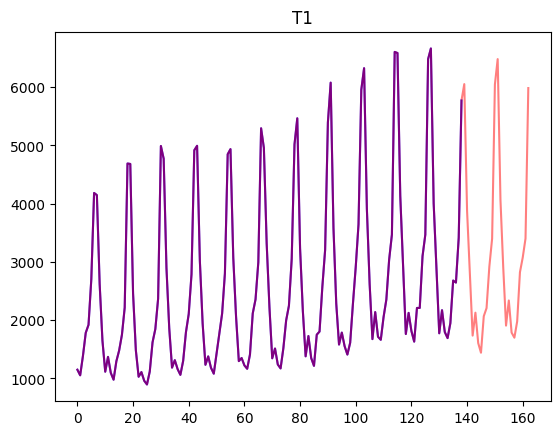

In [7]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots()
axes.plot(train_example["target"], color="blue")
axes.plot(validation_example["target"], color="red", alpha=0.5)
plt.title(validation_example["item_id"])
plt.show()

In [8]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [9]:
from functools import lru_cache # for memoisation

import pandas as pd
import numpy as np


def convert_to_pandas_period(date, freq): # use to convert date into timestamp
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]] # call each start date and pass into pd.Period to convert into YYYY-MM formate and save again to batch
    return batch

In [10]:
# for date in train_dataset['start'][:5]:
  # print(pd.Period(date, '1M'))


In [11]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq)) # set_transform -> apply train_dataset on the function inside set_transform()
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [12]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

# [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]

[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]


In [13]:
from gluonts.time_feature import time_features_from_frequency_str # monthly feature to create which wil repeat after 12 months

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function month_of_year at 0x79e2dc1bd120>]


In [14]:
timestamp = pd.Timestamp("1945-06-01")  # Example timestamp
time_features = time_features_from_frequency_str(freq)

time_features[0](timestamp)


-0.04545454545454547

In [15]:
# just to view what inside in time_features
timestamps = pd.date_range(start="2020-01-01", end="2022-01-05", freq=freq)

time_features = time_features_from_frequency_str(freq)

for timestamp in timestamps:
    feature_values = [feature_function(timestamp) for feature_function in time_features]
    print(f"Timestamp: {timestamp}, Feature Values: {feature_values}")


Timestamp: 2020-01-31 00:00:00, Feature Values: [-0.5]
Timestamp: 2020-02-29 00:00:00, Feature Values: [-0.40909090909090906]
Timestamp: 2020-03-31 00:00:00, Feature Values: [-0.3181818181818182]
Timestamp: 2020-04-30 00:00:00, Feature Values: [-0.2272727272727273]
Timestamp: 2020-05-31 00:00:00, Feature Values: [-0.13636363636363635]
Timestamp: 2020-06-30 00:00:00, Feature Values: [-0.04545454545454547]
Timestamp: 2020-07-31 00:00:00, Feature Values: [0.045454545454545414]
Timestamp: 2020-08-31 00:00:00, Feature Values: [0.13636363636363635]
Timestamp: 2020-09-30 00:00:00, Feature Values: [0.2272727272727273]
Timestamp: 2020-10-31 00:00:00, Feature Values: [0.31818181818181823]
Timestamp: 2020-11-30 00:00:00, Feature Values: [0.40909090909090906]
Timestamp: 2020-12-31 00:00:00, Feature Values: [0.5]
Timestamp: 2021-01-31 00:00:00, Feature Values: [-0.5]
Timestamp: 2021-02-28 00:00:00, Feature Values: [-0.40909090909090906]
Timestamp: 2021-03-31 00:00:00, Feature Values: [-0.3181818181

In [16]:
len(time_features)

1

In [17]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig( # config pass to the model
    prediction_length=prediction_length, # horizon lenght
    # context length:
    context_length=prediction_length * 2, # uses as history to learn
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence, # leg generate previously
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1, # The number of time-related features (month of the year, age) used in the model. len(time_features) is 1
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1, # there is one single static categorical feature (time series ID)
    # it has 366 possible values:
    cardinality=[len(train_dataset)], # number of element or IDs/products
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2], # how much a size or number in a list to represent a word. Embedding for Apple: tensor([[0.1234, 0.5678]] size of 2

    # transformer params:
    encoder_layers=4,  # Each layer performs self-attention and feedforward operations, capturing different aspects of the input sequence. A higher number of layers allows the model to capture more complex patterns and dependencies in the input data.
    decoder_layers=4,
    d_model=32, # In a transformer model, the input data goes through a series of transformations, and at each layer, it is represented by a set of vectors. d_model is set to 3, so each vector (e.g., query, key, value) and the final output representation has a length of 3. W_query = [0.1, 0.2, 0.3]  # Query projection matrix, W_key = [0.4, 0.5, 0.6]    # Key projection matrix, W_value = [0.7, 0.8, 0.9]
)   # if not specify the d_model, will set default value which is 64

model = TimeSeriesTransformerForPrediction(config)

'''
use of decoder_layers

1. The decoder takes the context-aware representations from the encoder as input.
2. It also takes the previously generated tokens from the output sequence (during the decoding process).
3. The decoder layer attends to both the encoder's output and the previous tokens to generate a context-aware representation for the next token in the output sequence.
4. The context-aware representation is then used to predict the probability distribution over the vocabulary for the next token.
5. This process is repeated until an end-of-sequence token is generated or a maximum sequence length is reached.

Input (English): "Hello, how are you?"
                             ↓
[Encoder Layer]  →  [Context-aware representations]
                             ↓
[Decoder Layer]  →  [Context-aware representation for next token] → [Next token in French]
                             ↓
[Decoder Layer]  →  [Context-aware representation for next token] → [Next token in French]
                             ↓
              ...
'''

'\nuse of decoder_layers\n\n1. The decoder takes the context-aware representations from the encoder as input.\n2. It also takes the previously generated tokens from the output sequence (during the decoding process).\n3. The decoder layer attends to both the encoder\'s output and the previous tokens to generate a context-aware representation for the next token in the output sequence.\n4. The context-aware representation is then used to predict the probability distribution over the vocabulary for the next token.\n5. This process is repeated until an end-of-sequence token is generated or a maximum sequence length is reached.\n\nInput (English): "Hello, how are you?"\n                             ↓\n[Encoder Layer]  →  [Context-aware representations]\n                             ↓\n[Decoder Layer]  →  [Context-aware representation for next token] → [Next token in French]\n                             ↓\n[Decoder Layer]  →  [Context-aware representation for next token] → [Next token in Fre

In [18]:
'''
# Hyperparameters
d_model = 3  # Dimensionality of the model's hidden representations

# Input data (sequence of numbers)
input_sequence = [1, 2, 3, 4, 5]

# Transformer layer (simplified for illustration)
def transformer_layer(input_vector):
    # Learnable parameters (weights and biases)
    W_query = [0.1, 0.2, 0.3]  # Query projection matrix
    W_key = [0.4, 0.5, 0.6]    # Key projection matrix
    W_value = [0.7, 0.8, 0.9]  # Value projection matrix
    b_query = 0.1               # Query bias
    b_key = 0.2                 # Key bias
    b_value = 0.3               # Value bias

    # Projection
    query = [W_query[i] * input_vector[i] for i in range(d_model)] + b_query
    key = [W_key[i] * input_vector[i] for i in range(d_model)] + b_key
    value = [W_value[i] * input_vector[i] for i in range(d_model)] + b_value

    # Attention (simplified)
    attention_weights = softmax(query * key)
    output_vector = attention_weights * value

    return output_vector

# Applying the transformer layer to the input sequence
output_representation = transformer_layer(input_sequence)
print("Output Representation:", output_representation)

'''

'\n# Hyperparameters\nd_model = 3  # Dimensionality of the model\'s hidden representations\n\n# Input data (sequence of numbers)\ninput_sequence = [1, 2, 3, 4, 5]\n\n# Transformer layer (simplified for illustration)\ndef transformer_layer(input_vector):\n    # Learnable parameters (weights and biases)\n    W_query = [0.1, 0.2, 0.3]  # Query projection matrix\n    W_key = [0.4, 0.5, 0.6]    # Key projection matrix\n    W_value = [0.7, 0.8, 0.9]  # Value projection matrix\n    b_query = 0.1               # Query bias\n    b_key = 0.2                 # Key bias\n    b_value = 0.3               # Value bias\n\n    # Projection\n    query = [W_query[i] * input_vector[i] for i in range(d_model)] + b_query\n    key = [W_key[i] * input_vector[i] for i in range(d_model)] + b_key\n    value = [W_value[i] * input_vector[i] for i in range(d_model)] + b_value\n\n    # Attention (simplified)\n    attention_weights = softmax(query * key)\n    output_vector = attention_weights * value\n\n    return ou

In [19]:
model.config.distribution_output # which probability distrbution is used to provide probablity predictions of forecast


'student_t'

In [20]:
from gluonts.time_feature import (time_features_from_frequency_str,TimeFeature,get_lags_for_frequency)
from gluonts.dataset.field_names import FieldName # define standardized field names that represent different components or properties of a time series dataset. Instead of using string literals to refer to specific fields in the dataset, using FieldName provides a standardized and more readable way to reference these fields. dataset["target"], you can use dataset[FieldName.TARGET]
from gluonts.transform import (
    AddAgeFeature, #  add an "age" feature to each time series, representing the time elapsed since the first observation.
    AddObservedValuesIndicator,  # adds a binary indicator for observed values. It helps distinguish between observed and missing values in the time series.
    AddTimeFeatures, # add feature like day of the week, month, or other relevant time-based information.
    AsNumpyArray, #  This transformation is used to convert data to NumPy arrays. It might be part of the preprocessing pipeline to ensure that the data is in a format suitable for model training.
    Chain, # allows chaining multiple transformations together. It's often used to create a sequential pipeline of transformations applied to time series data.
    ExpectedNumInstanceSampler, # This transformation is used to sample a specified number of instances (time series) from a dataset.
    InstanceSplitter, # splits each time series into training and prediction instances. It helps create the input-output pairs required for training a forecasting model.
    RemoveFields, #  removes specified fields (features) from the dataset. It's useful when certain fields are not needed for the forecasting task.
    SelectFields, # selects specific fields (features) from the dataset, keeping only the relevant ones.
    SetField, # sets the value of a specified field in the dataset. It allows modifying or setting specific fields to predefined values.
    TestSplitSampler, #  splitting a dataset into training and test sets. It helps in creating a separate set of data for evaluating the model's performance.
    Transformation, # base class for all transformations in GluonTS. It provides a common interface for applying transformations to time series data. define a class SquareValuesTransformation(Transformation) and here it is inherited from Transformation
    ValidationSplitSampler, # splitting a dataset into training and validation sets. It helps in monitoring the model's performance during training.
    VstackFeatures, # vertically stacks (concatenates) multiple time series datasets along the feature dimension. It's useful when combining datasets with similar structures. Usefull when you want to combine to create a larger dataset.
    RenameFields, # renames specified fields in the dataset. It allows customizing the field names for clarity or consistency.
)


In [21]:
config

TimeSeriesTransformerConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "attention_dropout": 0.1,
  "cardinality": [
    366
  ],
  "context_length": 48,
  "d_model": 32,
  "decoder_attention_heads": 2,
  "decoder_ffn_dim": 32,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 4,
  "distribution_output": "student_t",
  "dropout": 0.1,
  "embedding_dimension": [
    2
  ],
  "encoder_attention_heads": 2,
  "encoder_ffn_dim": 32,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 4,
  "feature_size": 22,
  "init_std": 0.02,
  "input_size": 1,
  "is_encoder_decoder": true,
  "lags_sequence": [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    11,
    12,
    13,
    23,
    24,
    25,
    35,
    36,
    37
  ],
  "loss": "nll",
  "model_type": "time_series_transformer",
  "num_dynamic_real_features": 0,
  "num_parallel_samples": 100,
  "num_static_categorical_features": 1,
  "num_static_real_features": 0,
  "num_time_features": 2,
  "prediction_length": 24,
  "scalin

In [22]:
FieldName.FEAT_AGE

'feat_dynamic_age'

In [23]:
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL) # FieldName.FEAT_STATIC_REAL (dikhavati khel)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain( # allows chaining multiple transformations together. It's often used to create a sequential pipeline of transformations applied to time series data.

        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0 else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            AddAgeFeature(
                target_field=FieldName.TARGET, # target value
                output_field=FieldName.FEAT_AGE, # feature name
                pred_length=config.prediction_length,
                log_scale=True, #  If set to true the age feature grows logarithmically otherwise linearly over time.
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME, # field name to use after vstack
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]+ ([FieldName.FEAT_DYNAMIC_REAL] if config.num_dynamic_real_features > 0 else []), # all fields inside the list to stack together
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={FieldName.FEAT_STATIC_CAT: "static_categorical_features",FieldName.FEAT_STATIC_REAL: "static_real_features",FieldName.FEAT_TIME: "time_features",FieldName.TARGET: "values",FieldName.OBSERVED_VALUES: "observed_mask",}
            ),
        ]
    )

In [25]:
from gluonts.transform.sampler import InstanceSampler # determines which training instances (or windows) to sample from the dataset for training the model
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {"train": train_sampler or ExpectedNumInstanceSampler(num_instances=1.0, min_future=config.prediction_length),
                        "validation": validation_sampler or ValidationSplitSampler(min_future=config.prediction_length),
                        "test": TestSplitSampler(),}[mode]
    print("instance_sampler - ", instance_sampler)
    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD, # padding steps added to make its length consistent
        start_field=FieldName.START, # refers to the field name used to specify the start time of a time series in the dataset. When creating or working with time series datasets, it's common to include a field that indicates the starting timestamp of each time series.
        forecast_start_field=FieldName.FORECAST_START, # refers to the field name used to specify the start time of the forecasting horizon in the dataset
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

'''

from gluonts.transform.sampler import InstanceSampler

# Create an instance of InstanceSampler with desired parameters
instance_sampler = InstanceSampler(num_instances=100, min_past=10, min_future=5)

# Apply the instance sampler to the dataset
train_dataset = instance_sampler(train_dataset)
'''


'\n\nfrom gluonts.transform.sampler import InstanceSampler\n\n# Create an instance of InstanceSampler with desired parameters\ninstance_sampler = InstanceSampler(num_instances=100, min_past=10, min_future=5)\n\n# Apply the instance sampler to the dataset\ntrain_dataset = instance_sampler(train_dataset)\n'

In [26]:
print(config.context_length )
print(config.lags_sequence)

48
[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]


In [34]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches # Prepare data in batches to be passed to a network. Input data is collected into batches of size batch_size and then columns are stacked on top of each other. In addition, the result is wrapped in output_type if provided.


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = ["past_time_features","past_values","past_observed_mask","future_time_features",]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + ["future_values","future_observed_mask",]

    transformation = create_transformation(freq, config) # its just a config rules, in the next line it is applied to main dataset
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream() # useful when you want to repeatedly iterate over the elements of a dataset, for example, during training a model with multiple epochs. Strean method returns an iterator that streams through the elements of the cyclic iterator and passed into instance_splitter
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(training_instances, batch_size=batch_size, shuffle_buffer_length=shuffle_buffer_length,field_names=TRAINING_INPUT_NAMES,output_type=torch.tensor,num_batches_per_epoch=num_batches_per_epoch,) # a batch typically consists of multiple time series instances, and stacking them can be more efficient for training deep learning models.
             # create stack of batches to process into the deep learning for on GPUs efficiently.

'''
Cyclic example
from gluonts.itertools import Cyclic

# Assume we have a list of numbers as our data
data_list = [1, 2, 3, 4, 5]

# Create a cyclic iterator for the data list
cyclic_data = Cyclic(data_list)

# Iterate through the cyclic data multiple times (for demonstration, let's do it twice)
for _ in range(2):
    for item in cyclic_data:
        print(item)
'''

"\nCyclic example\nfrom gluonts.itertools import Cyclic\n\n# Assume we have a list of numbers as our data\ndata_list = [1, 2, 3, 4, 5]\n\n# Create a cyclic iterator for the data list\ncyclic_data = Cyclic(data_list)\n\n# Iterate through the cyclic data multiple times (for demonstration, let's do it twice)\nfor _ in range(2):\n    for item in cyclic_data:\n        print(item)\n"

In [35]:
def create_backtest_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data)

    # we create a Validation Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in train mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=True)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )


In [36]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )


In [37]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)


instance_sampler -  axis=-1 min_past=0 min_future=24 num_instances=1.0 min_instances=0 total_length=0 n=0
instance_sampler -  axis=-1 min_past=0 min_future=24 allow_empty_interval=True


In [38]:
test_dataloader

In [39]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())
    print(v)



past_time_features torch.Size([256, 85, 2]) torch.FloatTensor
tensor([[[ 0.0455,  1.5051],
         [ 0.1364,  1.5185],
         [ 0.2273,  1.5315],
         ...,
         [-0.1364,  2.0569],
         [-0.0455,  2.0607],
         [ 0.0455,  2.0645]],

        [[ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [-0.5000,  1.8692],
         [-0.4091,  1.8751],
         [-0.3182,  1.8808]],

        [[ 0.1364,  1.9685],
         [ 0.2273,  1.9731],
         [ 0.3182,  1.9777],
         ...,
         [-0.0455,  2.2430],
         [ 0.0455,  2.2455],
         [ 0.1364,  2.2480]],

        ...,

        [[ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [-0.3182,  1.8062],
         [-0.2273,  1.8129],
         [-0.1364,  1.8195]],

        [[-0.3182,  2.0492],
         [-0.2273,  2.0531],
         [-0.1364,  2.0569],
         ...,
         [-0.5000,  2.2878],
         [-0.4091,  2.2900],
     

In [40]:
import numpy as np

# Assuming 'batch' is the dictionary containing tensors
for k, v in batch.items():
    print(k, v.shape, v.type())
    if k not in ["static_categorical_features"]:
        print(np.array(v[0]))  # Convert the first instance to a NumPy array for inspection
    else:
        print(v[0].item())  # Convert the static_categorical_features to a Python scalar for inspection
    print("\n")

past_time_features torch.Size([256, 85, 2]) torch.FloatTensor
[[ 0.04545455  1.50515   ]
 [ 0.13636364  1.5185139 ]
 [ 0.22727273  1.5314789 ]
 [ 0.3181818   1.5440681 ]
 [ 0.4090909   1.5563025 ]
 [ 0.5         1.5682018 ]
 [-0.5         1.5797836 ]
 [-0.4090909   1.5910646 ]
 [-0.3181818   1.60206   ]
 [-0.22727273  1.6127839 ]
 [-0.13636364  1.6232493 ]
 [-0.04545455  1.6334685 ]
 [ 0.04545455  1.6434526 ]
 [ 0.13636364  1.6532125 ]
 [ 0.22727273  1.6627579 ]
 [ 0.3181818   1.6720979 ]
 [ 0.4090909   1.6812413 ]
 [ 0.5         1.690196  ]
 [-0.5         1.69897   ]
 [-0.4090909   1.7075702 ]
 [-0.3181818   1.7160033 ]
 [-0.22727273  1.7242758 ]
 [-0.13636364  1.7323937 ]
 [-0.04545455  1.7403626 ]
 [ 0.04545455  1.748188  ]
 [ 0.13636364  1.7558749 ]
 [ 0.22727273  1.763428  ]
 [ 0.3181818   1.7708521 ]
 [ 0.4090909   1.7781513 ]
 [ 0.5         1.7853298 ]
 [-0.5         1.7923918 ]
 [-0.4090909   1.7993405 ]
 [-0.3181818   1.80618   ]
 [-0.22727273  1.8129133 ]
 [-0.13636364  1.819

In [41]:
batch["past_values"]

tensor([[4.9912e+03, 4.7729e+03, 2.8947e+03,  ..., 3.0386e+03, 3.4706e+03,
         6.6062e+03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.3495e+04, 3.0509e+04,
         4.5439e+04],
        [1.1760e+04, 1.1576e+04, 1.8495e+04,  ..., 1.4650e+04, 1.8571e+04,
         1.7641e+04],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.3600e+02, 6.8000e+01,
         4.0000e+01],
        [1.9800e+02, 2.1600e+02, 1.4400e+02,  ..., 3.9100e+02, 2.4800e+03,
         2.8800e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.0000e+01, 1.6000e+01,
         1.6000e+01]])

In [42]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)


In [43]:
print("Loss:", outputs.loss.item())


Loss: 9.134961128234863


In [44]:
from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator() #
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(model,optimizer,train_dataloader,)

model.train() # Activate certain functionlity 1. Activating Dropout Layers 2. Activating Batch Normalization Layers. After the loop, you might switch the model to evaluation mode using model.eval() when evaluating on a validation or test set. This ensures that dropout and batch normalization layers behave differently during training and evaluation, helping to achieve better generalization performance. In batch normalisation, mini-batch allows Batch Normalization to adapt to the statistical properties of the current batch of data.
# Each mini-batch may have different distributions of features, and normalizing within the mini-batch helps in stabilizing and accelerating the training process.
# Batch Normalization introduces a form of noise or randomness. This is because the mean and standard deviation are computed based on a subset of the training data. This stochastic element can act as a form of regularization,
for epoch in range(20):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad() # In PyTorch, the optimizer keeps track of the gradients of the model's parameters with respect to the loss. Before starting the backward pass (accelerator.backward(loss)), it's necessary to zero out the gradients from the previous batch. This is because PyTorch accumulates gradients by default (useful in some cases like RNNs), and if you don't zero them, the gradients will accumulate across batches.
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device) # .to(device): This is a PyTorch method used to move the tensor to a specific device. In deep learning, computations are performed on either a CPU or a GPU. The to method allows you to move a tensor between these devices. The device variable should contain the target device, which could be a GPU (e.g., "cuda:0") or a CPU (e.g., "cpu").
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step() # computing the gradients of the model's parameters with respect to the loss (during the backward pass) and before the next forward pass.

        if idx % 100 == 0: # prints the value of the loss every 100 iterations of the inner training loop.
            print(loss.item())


8.982010841369629
7.660963535308838
8.05146312713623
7.611759662628174
6.7791748046875
7.004070281982422
7.117321014404297
7.1883769035339355
6.8513054847717285
7.732827663421631
6.940942287445068
6.83173942565918
7.238381862640381
7.182339191436768
7.135033130645752
6.926421642303467
6.955127716064453
7.375373840332031
7.3496246337890625
7.574355602264404


In [45]:
model.eval() # To put model on evaluation mode. to perform inference or evaluation rather than training.
# In the code snippet above, model.eval() is used before performing inference on the evaluation dataset. The torch.no_grad() context manager is also used to disable gradient computation during inference, saving memory and speeding up the process. The model is switched back to training mode with model.train() when resuming training.


TimeSeriesTransformerForPrediction(
  (model): TimeSeriesTransformerModel(
    (scaler): TimeSeriesMeanScaler()
    (embedder): TimeSeriesFeatureEmbedder(
      (embedders): ModuleList(
        (0): Embedding(366, 2)
      )
    )
    (encoder): TimeSeriesTransformerEncoder(
      (value_embedding): TimeSeriesValueEmbedding(
        (value_projection): Linear(in_features=22, out_features=32, bias=False)
      )
      (embed_positions): TimeSeriesSinusoidalPositionalEmbedding(72, 32)
      (layers): ModuleList(
        (0-3): 4 x TimeSeriesTransformerEncoderLayer(
          (self_attn): TimeSeriesTransformerAttention(
            (k_proj): Linear(in_features=32, out_features=32, bias=True)
            (v_proj): Linear(in_features=32, out_features=32, bias=True)
            (q_proj): Linear(in_features=32, out_features=32, bias=True)
            (out_proj): Linear(in_features=32, out_features=32, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((32,), eps=1e-05, element

In [46]:
model.eval()

forecasts = [] # each batch forecast is loaded into, for 1 time series there will be 100 forecast for next 24 and for 366 products there will 36000 forecast.  Use np.vstack(forecasts).shape to see (36000, 24)


for batch in test_dataloader: # remember that there were 100 batches for one product/time series which will generate 24 horizon length prediction in each
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())


In [47]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(366, 100, 24)


In [48]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length] # select starting to -24
    ground_truth = ts["target"][-prediction_length:] # select -24 to end
    mase = mase_metric.compute(predictions=forecast_median[item_id],references=np.array(ground_truth),training=np.array(training_data),
                               periodicity=get_seasonality(freq)) # mase_metric uses predictions, ground_truth(actual), training to calculate the metric
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])


In [49]:
print(f"MASE: {np.mean(mase_metrics)}")

# MASE: 1.2564196892177717

print(f"sMAPE: {np.mean(smape_metrics)}")

# sMAPE: 0.1609541520852549

MASE: 1.534603009313209
sMAPE: 0.198890014233196


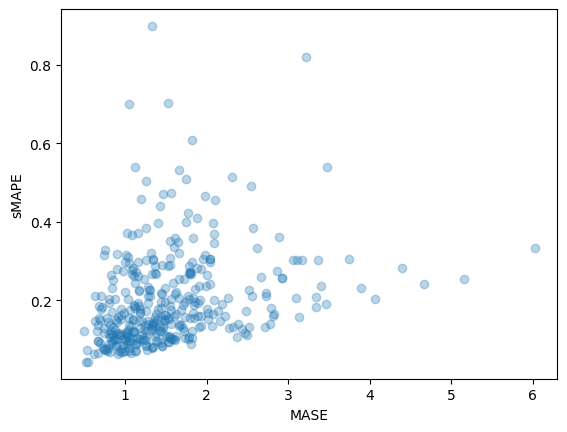

In [50]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

In [51]:
import matplotlib.dates as mdates

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(start=test_dataset[ts_index][FieldName.START],periods=len(test_dataset[ts_index][FieldName.TARGET]),freq=freq,).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(index[-2*prediction_length:],test_dataset[ts_index]["target"][-2*prediction_length:],label="actual",) # not puch entire actual data, just pich up 24 * 2 - 48 data points

    plt.plot(index[-prediction_length:],np.median(forecasts[ts_index], axis=0),label="median",) # pick up only horizon 24 forecast data

    plt.fill_between(index[-prediction_length:], forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0),forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0),alpha=0.3, interpolate=True,label="+/- 1-std", )
    plt.legend()
    plt.show()


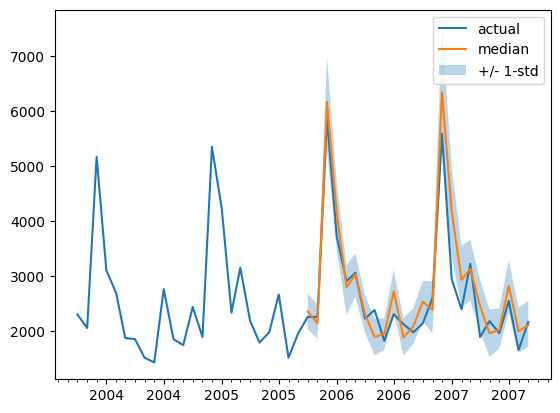

In [52]:
plot(334)

